In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import NASNetLarge
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
import seaborn as sns

2025-01-09 13:36:20.957174: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-09 13:36:20.957212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-09 13:36:20.958687: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-09 13:36:20.966547: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
base_dir = '../Dataset_BUSI_with_GT'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [3]:
#Normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#Train,Val and Test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='binary',
    classes=['benign','malignant']
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='binary',
    classes=['benign','malignant']
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(331, 331),
    batch_size=32,
    class_mode='binary',
    shuffle=False,
    classes=['benign','malignant']
)

Found 1619 images belonging to 2 classes.
Found 346 images belonging to 2 classes.
Found 349 images belonging to 2 classes.


In [4]:
base_model = NASNetLarge(weights='imagenet', include_top=False, input_shape=(331, 331, 3))

2025-01-09 13:36:25.662733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31124 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


In [5]:
#Final layers set
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

In [6]:
model = Model(inputs=base_model.input, outputs=output_layer)

In [7]:
#Freeze early layers
for layer in base_model.layers:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10


2025-01-09 13:37:20.072546: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
2025-01-09 13:37:23.901262: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f03c86eaac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-09 13:37:23.901299: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-DGXS-32GB, Compute Capability 7.0
2025-01-09 13:37:23.911555: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736429844.022720   13448 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


51/51 [==============================] - 79s 726ms/step - loss: 0.5063 - accuracy: 0.7678 - val_loss: 0.3768 - val_accuracy: 0.8179
Epoch 2/10
51/51 [==============================] - 23s 457ms/step - loss: 0.3013 - accuracy: 0.8721 - val_loss: 0.3408 - val_accuracy: 0.8266
Epoch 3/10
51/51 [==============================] - 23s 451ms/step - loss: 0.2292 - accuracy: 0.9080 - val_loss: 0.2490 - val_accuracy: 0.8873
Epoch 4/10
51/51 [==============================] - 23s 453ms/step - loss: 0.1684 - accuracy: 0.9382 - val_loss: 0.2394 - val_accuracy: 0.9104
Epoch 5/10
51/51 [==============================] - 23s 441ms/step - loss: 0.1118 - accuracy: 0.9623 - val_loss: 0.1810 - val_accuracy: 0.9306
Epoch 6/10
51/51 [==============================] - 24s 462ms/step - loss: 0.0789 - accuracy: 0.9753 - val_loss: 0.2029 - val_accuracy: 0.9277
Epoch 7/10
51/51 [==============================] - 23s 449ms/step - loss: 0.0453 - accuracy: 0.9932 - val_loss: 0.2173 - val_accuracy: 0.9162
Epoch 8/10

In [9]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

11/11 [==============================] - 6s 508ms/step - loss: 0.2171 - accuracy: 0.9370
Test accuracy: 0.9369627237319946


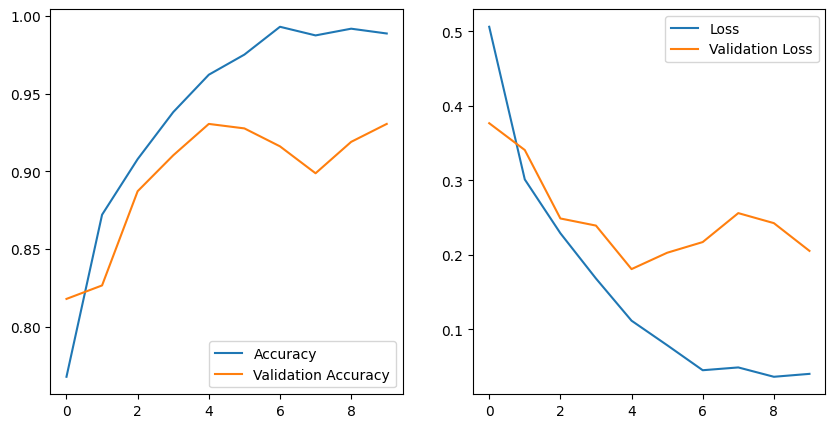

In [11]:
#Accuracy,Val accuracy, loss and val loss graphs
acc = history.history['accuracy']
val_acc =  history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Accuracy')
plt.plot(epochs_range,val_acc,label="Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Loss')
plt.plot(epochs_range,val_loss,label="Validation Loss")
plt.legend()
plt.show()

In [12]:
predictions = model.predict(test_generator)
binary_predictions = (predictions > 0.5).astype(int).flatten()

true_labels = test_generator.classes

11/11 [==============================] - 14s 344ms/step


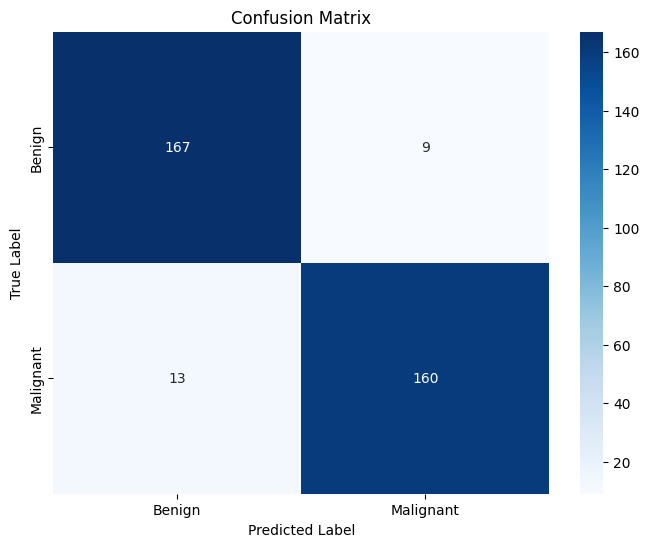

In [13]:
#Confussion matrix
cm = confusion_matrix(true_labels, binary_predictions)

#Confusion matrix plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [22]:
model.save('NASNet_2class_low')

INFO:tensorflow:Assets written to: NASNet_2class_low/assets


INFO:tensorflow:Assets written to: NASNet_2class_low/assets
